# **LSTM을 활용한 이미지 분류 (MNIST 데이터셋)**

## MNIST 데이터셋 이미지

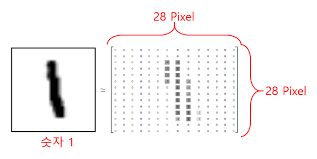

### 이미지를 Time Sequence로 바라보고 LSTM을 적용

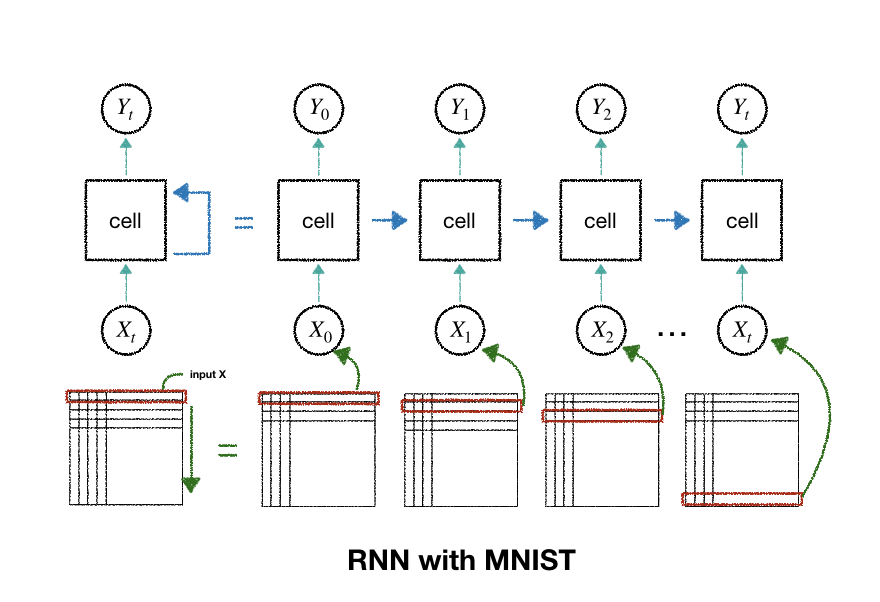

## **PyTorch 라이브러리 불러오기**

In [ ]:
import torch
from torch import nn

## **Torchvision 라이브러리 불러오기**

In [ ]:
import torchvision
from torchvision import transforms

## **MNIST 데이터셋 불러오기**

In [ ]:
trainDataset = torchvision.datasets.MNIST(root="/data",
                                          train=True,
                                          transform=transforms.ToTensor(),
                                          download=True)
testDataset = torchvision.datasets.MNIST(root="/data",
                                         train=False,
                                         transform=transforms.ToTensor())

## **훈련 및 모델 하이퍼파라미터 선정**

In [ ]:
opt = {"seqLen":28, "inputSize":28, "hiddenSize":128, "numLayer":1,
       "numClass":10, "batchSize":128, "numEpoch":20, "lr":1e-3, "seed":42}

## **Seed 고정**

In [ ]:
import random
import numpy as np

In [ ]:
def fixSeed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
fixSeed(opt["seed"])

## **사용 Device 정하기 (GPU 또는 CPU)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Device Type : {device}")

## **DataLoader 생성**

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataset,
                                          batch_size=opt["batchSize"],
                                          drop_last=True,
                                          shuffle=True)

In [ ]:
testLoader = torch.utils.data.DataLoader(testDataset,
                                         batch_size=opt["batchSize"],
                                         drop_last=False,
                                         shuffle=False)

## **LSTM**

### PyTorch LSTM

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

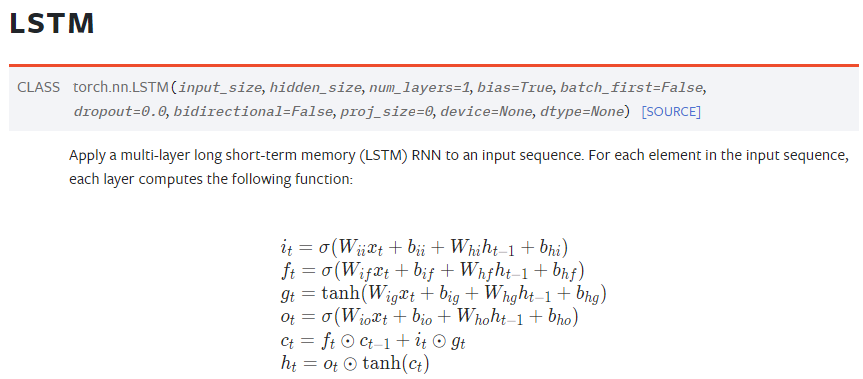

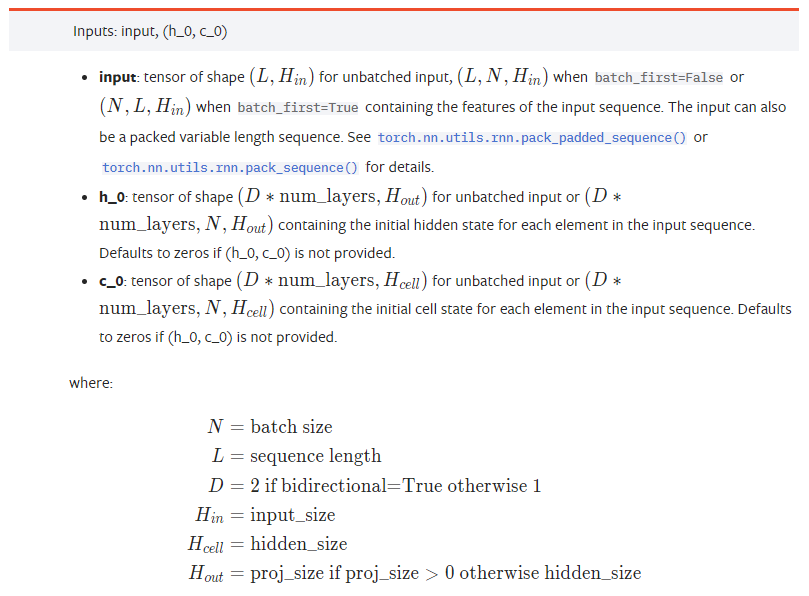

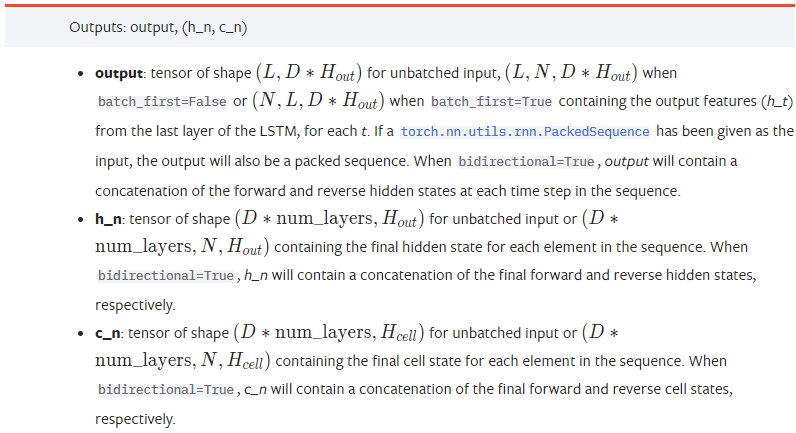

### **LSTM 모델 클래스 정의**

#### Many-to-One 유형



In [ ]:
class LSTM(nn.Module) :
    def __init__(self, inputSize, hiddenSize, numLayer, numClass) :
        # Inheritance
        super(LSTM, self).__init__()

        # Initialize Variables
        self.hiddenSize = hiddenSize
        self.numLayer = numLayer
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayer, batch_first=True)
        self.fc = nn.Linear(hiddenSize, numClass)

    def forward(self, input) :
        # Input Shape → (batchSize, length, inputSize)
        # 최초의 Hidden State와 Cell State → 초기화
        # 만약 Bi-Directional LSTM이라면 아래의 Hidden Stated와 Cell State의 첫번째 차원은 2*self.numLayer
        h0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)
        c0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)

        # LSTM 순전파
        output, _ = self.lstm(input, (h0, c0)) # output : (batch, length, hiddenSize) | (hn, cn)은 필요 없음으로 _로 Return

        # 마지막 Time Step (Sequence Length)의 Hidden State를 사용해 Class들의 Logit을 반환 (hiddenSize → numClass)
        output = self.fc(output[:, -1, :])

        return output

### **훈련 과정 요약을 위한 Average Meter 인스턴스 생성**

In [ ]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
trainLoss, testLoss = AverageMeter(), AverageMeter()

In [ ]:
trainAcc, testAcc = AverageMeter(), AverageMeter()

### **훈련 결과 저장을 위한 Python List 인스턴스 생성**

In [ ]:
oneLayerTrainLossList, oneLayerTestLossList = [], []

In [ ]:
oneLayerTrainAccList, oneLayerTestAccList = [], []

In [ ]:
bestTestAcc = 0

### **LSTM 모델 훈련**

#### **LSTM 모델 인스턴스 생성**

In [ ]:
fixSeed(opt["seed"])

In [ ]:
model = LSTM(opt["inputSize"], opt["hiddenSize"], opt["numLayer"], opt["numClass"]).to(device)

#### **LSTM 모델 파라미터 개수 계산**

In [ ]:
numParameter = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Number of Trainable Parameters : {numParameter:,}")

#### **손실 함수 인스턴스 생성**

In [ ]:
criterion = nn.CrossEntropyLoss()

#### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

### **정확도 계산을 위한 torchmetrics 라이브러리 설치**

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=opt["numClass"]).to(device)

#### **훈련 진행**

##### Progress Bar 시각화를 위한 TQDM 라이브러리 불러오기

In [ ]:
from tqdm import tqdm

In [ ]:
for epoch in range(1, opt["numEpoch"]+1) :
  ########################################################################################################################################

    trainBar = tqdm(trainLoader) # Create TQDM Instance
    trainLoss.reset(), trainAcc.reset() # Reset AverageMeter Instance

    model.train() # Train Mode

    for data in trainBar :
      images, labels = data # Unpack Tuple Elements
      images, labels = images.to(device), labels.to(device) # Assign Device
      images = images.reshape(-1, opt["seqLen"], opt["inputSize"]) # (batchSize, 1, 28, 28) → (batchSize, 28, 28)

      optimizer.zero_grad() # Set Gradient to 0
      pred = model(images) # Get Prediction
      loss = criterion(pred, labels) # Compute Loss
      loss.backward() # Back-Propagation
      optimizer.step() # Update Weight

      trainLoss.update(loss.detach().cpu().item(), opt["batchSize"]) # Compute Averaged Loss
      trainAcc.update(accuracy(pred, labels).detach().cpu().item(), opt["batchSize"]) # Compute Averaged Accuracy
      trainBar.set_description(desc=f"[{epoch}/{opt['numEpoch']}] [Train] < Loss:{trainLoss.avg:.4f} | Accuracy:{trainAcc.avg:.4f} >")

    oneLayerTrainLossList.append(trainLoss.avg), oneLayerTrainAccList.append(trainAcc.avg)

    ########################################################################################################################################

    testBar = tqdm(testLoader) # Create TQDM Instance
    testLoss.reset(), testAcc.reset() # Reset AverageMeter Instance

    model.eval() # Evaulation Mode

    for data in testBar :
      images, labels = data # Unpack Tuple Elements
      images, labels = images.to(device), labels.to(device) # Assign Device
      images = images.reshape(-1, opt["seqLen"], opt["inputSize"]) # (batchSize, 1, 28, 28) → (batchSize, 28, 28)

      with torch.no_grad() :
        pred = model(images) # Get Prediction
        loss = criterion(pred, labels) # Compute Loss

        testLoss.update(loss.detach().cpu().item(), opt["batchSize"]) # Compute Averaged Loss
        testAcc.update(accuracy(pred, labels).detach().cpu().item(), opt["batchSize"]) # Compute Averaged Accuracy
        testBar.set_description(desc=f"[{epoch}/{opt['numEpoch']}] [Test] < Loss:{testLoss.avg:.4f} | Accuracy:{testAcc.avg:.4f} >")

    oneLayerTestLossList.append(testLoss.avg), oneLayerTestAccList.append(testAcc.avg)

    if testAcc.avg > bestTestAcc :
      bestTestAcc = testAcc.avg
      torch.save(model.state_dict(), "Best-RNN.pth")

    torch.save(model.state_dict(), "Latest-RNN.pth")

In [ ]:
print(f"Best Test Accuracy : {bestTestAcc:.4f}")

### **LSTM 모델 훈련 과정 시각화**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), oneLayerTrainLossList, label="Train Loss")
plt.plot(np.arange(opt["numEpoch"]), oneLayerTestLossList, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), oneLayerTrainAccList, label="Train Accuracy")
plt.plot(np.arange(opt["numEpoch"]), oneLayerTestAccList, label="Test Accuracy")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("[LSTM] Train Accuracy vs. Test Accuracy")
plt.show()

## **Multi-Layer LSTM**

### **Stacked LSTM 구현**

In [ ]:
opt["numLayer"] = 5

### **훈련 결과 저장을 위한 Python List 인스턴스 생성**

In [ ]:
multiLayerTrainLossList, multiLayerTestLossList = [], []

In [ ]:
multiLayerTrainAccList, multiLayerTestAccList = [], []

In [ ]:
bestTestAcc = 0

#### **LSTM 모델 인스턴스 생성**

In [ ]:
fixSeed(opt["seed"])

In [ ]:
model = LSTM(opt["inputSize"], opt["hiddenSize"], opt["numLayer"], opt["numClass"]).to(device)

#### **LSTM 모델 파라미터 개수 계산**

In [ ]:
numParameter = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Number of Trainable Parameters : {numParameter:,}")

#### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

#### **훈련 진행**

In [ ]:
for epoch in range(1, opt["numEpoch"]+1) :
  ########################################################################################################################################

    trainBar = tqdm(trainLoader) # Create TQDM Instance
    trainLoss.reset(), trainAcc.reset() # Reset AverageMeter Instance

    model.train() # Train Mode

    for data in trainBar :
      images, labels = data # Unpack Tuple Elements
      images, labels = images.to(device), labels.to(device) # Assign Device
      images = images.reshape(-1, opt["seqLen"], opt["inputSize"]) # (batchSize, 1, 28, 28) → (batchSize, 28, 28)

      optimizer.zero_grad() # Set Gradient to 0
      pred = model(images) # Get Prediction
      loss = criterion(pred, labels) # Compute Loss
      loss.backward() # Back-Propagation
      optimizer.step() # Update Weight

      trainLoss.update(loss.detach().cpu().item(), opt["batchSize"]) # Compute Averaged Loss
      trainAcc.update(accuracy(pred, labels).detach().cpu().item(), opt["batchSize"]) # Compute Averaged Accuracy
      trainBar.set_description(desc=f"[{epoch}/{opt['numEpoch']}] [Train] < Loss:{trainLoss.avg:.4f} | Accuracy:{trainAcc.avg:.4f} >")

    multiLayerTrainLossList.append(trainLoss.avg), multiLayerTrainAccList.append(trainAcc.avg)

    ########################################################################################################################################

    testBar = tqdm(testLoader) # Create TQDM Instance
    testLoss.reset(), testAcc.reset() # Reset AverageMeter Instance

    model.eval() # Evaulation Mode

    for data in testBar :
      images, labels = data # Unpack Tuple Elements
      images, labels = images.to(device), labels.to(device) # Assign Device
      images = images.reshape(-1, opt["seqLen"], opt["inputSize"]) # (batchSize, 1, 28, 28) → (batchSize, 28, 28)

      with torch.no_grad() :
        pred = model(images) # Get Prediction
        loss = criterion(pred, labels) # Compute Loss

        testLoss.update(loss.detach().cpu().item(), opt["batchSize"]) # Compute Averaged Loss
        testAcc.update(accuracy(pred, labels).detach().cpu().item(), opt["batchSize"]) # Compute Averaged Accuracy
        testBar.set_description(desc=f"[{epoch}/{opt['numEpoch']}] [Test] < Loss:{testLoss.avg:.4f} | Accuracy:{testAcc.avg:.4f} >")

    multiLayerTestLossList.append(testLoss.avg), multiLayerTestAccList.append(testAcc.avg)

    if testAcc.avg > bestTestAcc :
      bestTestAcc = testAcc.avg
      torch.save(model.state_dict(), "Best-RNN.pth")

    torch.save(model.state_dict(), "Latest-RNN.pth")

In [ ]:
print(f"Best Test Accuracy : {bestTestAcc:.4f}")

### **LSTM 모델 훈련 과정 시각화**

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), multiLayerTrainLossList, label="Train Loss")
plt.plot(np.arange(opt["numEpoch"]), multiLayerTestLossList, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), multiLayerTrainAccList, label="Train Accuracy")
plt.plot(np.arange(opt["numEpoch"]), multiLayerTestAccList, label="Test Accuracy")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("[LSTM] Train Accuracy vs. Test Accuracy")
plt.show()

## **One-Layer LSTM vs. Multi-Layer LSTM**

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), oneLayerTestLossList, label="Test Loss (One-Layer)")
plt.plot(np.arange(opt["numEpoch"]), multiLayerTestLossList, label="Test Loss (Multi-Layer)")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("[LSTM] One-Layer Test Loss vs. Multi-Layer Test Loss")
plt.show()

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), oneLayerTestAccList, label="Test Accuracy (One-Layer)")
plt.plot(np.arange(opt["numEpoch"]), multiLayerTestAccList, label="Test Accuracy (Multi-Layer)")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("[LSTM] One-Layer Test Accuracy vs. Multi-Layer Test Accuracy")
plt.show()